In [115]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import lightgbm as lgb
import xgboost as xgb
import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV
import gc    #garbage collector
from catboost import CatBoostRegressor

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import sem, t
from scipy import mean

pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)


In [116]:
def normal_confidence_interval(data,confidence = 0.95):

    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    return m-h,m+h

In [117]:
def distribute_interval(data,mean = 0, bias = 0.1, start = 20,confidence = 0.95):
    count = len(data)
    i = start
    while True :
        inter_count = len(data.loc[(data > mean - i * bias) & (data < mean + i * bias)]) 
        #data.loc[(data > mean - i * bias) & (data < mean + i * bias)].shape[0]
        if inter_count / count < confidence :
            i += 1
        else:
            break
    return i * bias

In [118]:
%%time
train = pd.read_csv('./input/train.csv', parse_dates=['first_active_month'])
test = pd.read_csv('./input/test.csv', parse_dates=['first_active_month'])
submission = pd.read_csv('./input/sample_submission.csv')

CPU times: user 283 ms, sys: 19.9 ms, total: 303 ms
Wall time: 303 ms


In [119]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [120]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [121]:
e = pd.read_excel('./input/Data_Dictionary.xlsx', sheet_name='train')
e

,train.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Unique card identifier
3,first_active_month,"'YYYY-MM', month of first purchase"
4,feature_1,Anonymized card categorical feature
5,feature_2,Anonymized card categorical feature
6,feature_3,Anonymized card categorical feature
7,target,Loyalty numerical score calculated 2 months after historical and evaluation period


In [122]:
train['feature_1'] = train['feature_1'].astype('category')
train['feature_2'] = train['feature_2'].astype('category')
train['feature_3'] = train['feature_3'].astype('category')
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [123]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null category
feature_2             201917 non-null category
feature_3             201917 non-null category
target                201917 non-null float64
dtypes: category(3), datetime64[ns](1), float64(1), object(1)
memory usage: 5.2+ MB


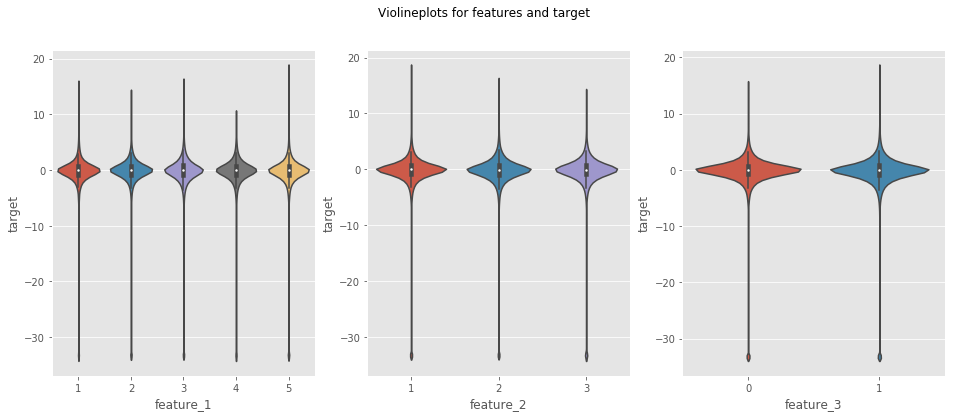

In [124]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6))
plt.suptitle('Violineplots for features and target');
sns.violinplot(x="feature_1", y="target", data=train, ax=ax[0], title='feature_1');
sns.violinplot(x="feature_2", y="target", data=train, ax=ax[1], title='feature_2');
sns.violinplot(x="feature_3", y="target", data=train, ax=ax[2], title='feature_3');

In [125]:
low,high = normal_confidence_interval(train['target'])
print(low,high)

train_target_interval = distribute_interval(train['target'])
print(train_target_interval)

-0.4104313520926402 -0.37684124606333463
4.0


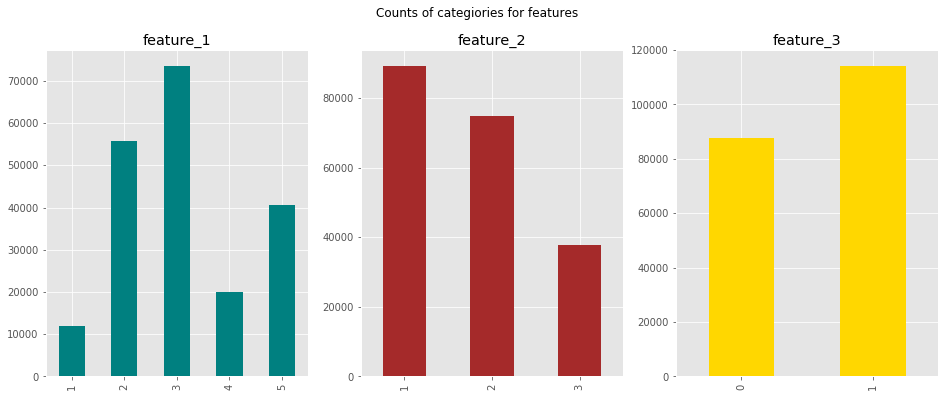

In [126]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6));
train['feature_1'].value_counts().sort_index().plot(kind='bar', ax=ax[0], color='teal', title='feature_1');
train['feature_2'].value_counts().sort_index().plot(kind='bar', ax=ax[1], color='brown', title='feature_2');
train['feature_3'].value_counts().sort_index().plot(kind='bar', ax=ax[2], color='gold', title='feature_3');
plt.suptitle('Counts of categiories for features');

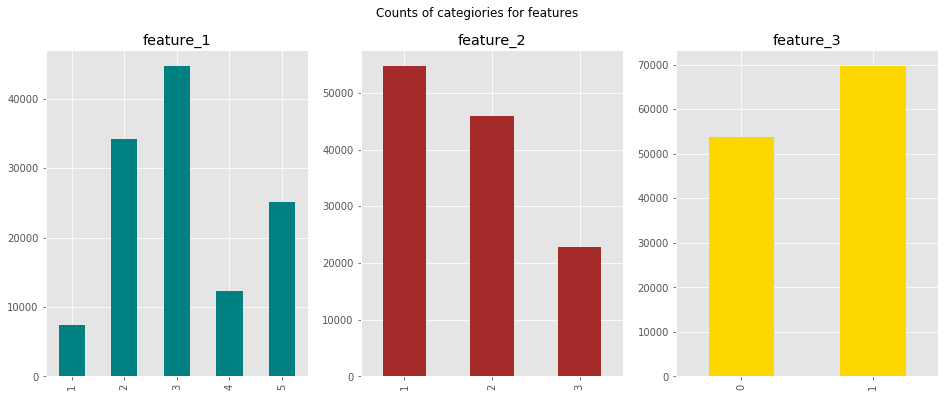

In [127]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6));
test['feature_1'].value_counts().sort_index().plot(kind='bar', ax=ax[0], color='teal', title='feature_1');
test['feature_2'].value_counts().sort_index().plot(kind='bar', ax=ax[1], color='brown', title='feature_2');
test['feature_3'].value_counts().sort_index().plot(kind='bar', ax=ax[2], color='gold', title='feature_3');
plt.suptitle('Counts of categiories for features');

In [128]:
test['feature_1'] = test['feature_1'].astype('category')
test['feature_2'] = test['feature_2'].astype('category')
test['feature_3'] = test['feature_3'].astype('category')

In [129]:
d1 = train['first_active_month'].value_counts().sort_index()
d2 = test['first_active_month'].value_counts().sort_index()
data = [go.Scatter(x=d1.index, y=d1.values, name='train'), go.Scatter(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title = "Counts of first active",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Count'),
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

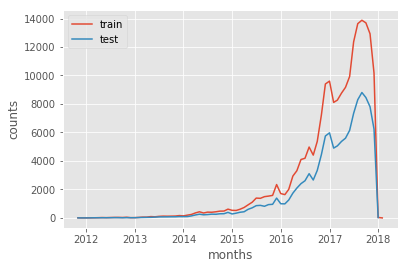

train max month:2017-09-01 00:00:00,counts:13878
test max month:2017-09-01 00:00:00,counts:8805


In [130]:
d1 = train['first_active_month'].value_counts().sort_index()
d2 = test['first_active_month'].value_counts().sort_index()

# plot with various axes scales
plt.figure(1)

plt.plot(d1,label="train")
plt.plot(d2,label="test")
plt.xlabel('months')
plt.ylabel('counts')
plt.legend()
plt.show()

print('train max month:{0},counts:{1}'.format(d1.argmax(0), d1.max()))
print('test max month:{0},counts:{1}'.format(d2.argmax(0), d2.max()))

In [131]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0
2,2017-08-01,C_ID_b709037bc5,5,1,1
3,2017-12-01,C_ID_d27d835a9f,2,1,0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1


In [132]:
test.loc[test['first_active_month'].isna(), 'first_active_month'] = test.loc[(test['feature_1'] == 5) & (test['feature_2'] == 2) & (test['feature_3'] == 1), 'first_active_month'].min()

Text(0.5, 1.0, 'Target distribution')

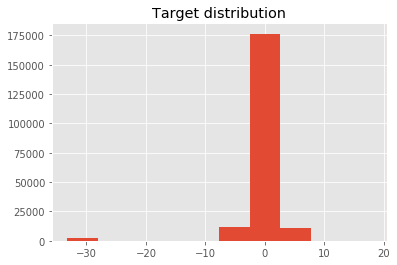

In [133]:
plt.hist(train['target'])
plt.title('Target distribution')

In [134]:
print('There are {0} samples with target lower than -20.'.format(train.loc[train.target < -20].shape[0]))
print('There are {0} samples with target lower than 0 and greater than -10.'.format(train.loc[(train.target < 1) & (train.target > -10)].shape[0]))
print('There are {0} samples with target lower than 10 and greater than 0.'.format(train.loc[(train.target > -1) & (train.target < 10)].shape[0]))
print('There are {0} samples with target greater than 10.'.format(train.loc[train.target > 10].shape[0]))

There are 2207 samples with target lower than -20.
There are 158636 samples with target lower than 0 and greater than -10.
There are 156127 samples with target lower than 10 and greater than 0.
There are 48 samples with target greater than 10.


In [135]:
max_date = train['first_active_month'].dt.date.max()
def process_main(df):
    date_parts = ["year", "weekday", "month"]
    for part in date_parts:
        part_col = 'first_active_month' + "_" + part
        df[part_col] = getattr(df['first_active_month'].dt, part).astype(int)
            
    df['elapsed_time'] = (max_date - df['first_active_month'].dt.date).dt.days
    
    return df

In [136]:
train = process_main(train)
test = process_main(test)

In [137]:
historical_transactions = pd.read_csv('./input/historical_transactions.csv')
e = pd.read_excel('./input/Data_Dictionary.xlsx', sheet_name='history')
e

,historical_transactions.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


In [138]:
#### deal with historical_transactions

print(historical_transactions.shape[0],'samples in data')
historical_transactions.head()

29112361 samples in data


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [139]:
# let's convert the authorized_flag to a binary value.
historical_transactions['authorized_flag'] = historical_transactions['authorized_flag'].apply(lambda x: 1 if x == 'Y' else 0)

At average 91.3545% transactions are authorized


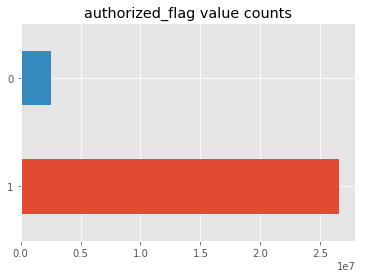

In [140]:
print("At average {0:.4f}% transactions are authorized".format(historical_transactions['authorized_flag'].mean() * 100))
historical_transactions['authorized_flag'].value_counts().plot(kind='barh', title='authorized_flag value counts');

In [141]:
authorized_card_rate = historical_transactions.groupby(['card_id'])['authorized_flag'].mean().sort_values()
authorized_card_rate.head()

card_id
C_ID_744d26ea32    0.030488
C_ID_bb8dd137c9    0.037037
C_ID_e56202cd39    0.042105
C_ID_4feacff118    0.050000
C_ID_c27b4f80f7    0.054545
Name: authorized_flag, dtype: float64

In [142]:
authorized_card_rate.tail()

card_id
C_ID_d048b7cc60    1.0
C_ID_4e45fcdb43    1.0
C_ID_9f3ee1305e    1.0
C_ID_1b52a3e21b    1.0
C_ID_d3c3d988d5    1.0
Name: authorized_flag, dtype: float64

In [143]:
authorized_card_rate=round(authorized_card_rate,2)
authorized_rate = authorized_card_rate.value_counts().sort_index()
authorized_rate.head()

0.03    1
0.04    2
0.05    2
0.06    1
0.07    4
Name: authorized_flag, dtype: int64

In [144]:
authorized_rate.tail()

0.96    18613
0.97    17980
0.98    16276
0.99    10408
1.00    50594
Name: authorized_flag, dtype: int64

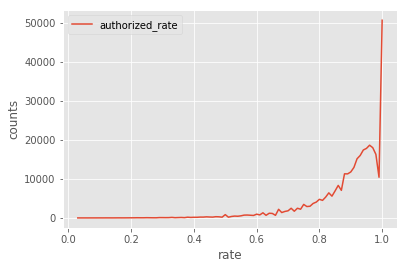

In [145]:
# plot with various axes scales
plt.figure(1)

plt.plot(authorized_rate,label="authorized_rate")
plt.xlabel('rate')
plt.ylabel('counts')
plt.legend()
plt.show()

In [146]:
authorize_card_05= authorized_card_rate.loc[authorized_card_rate.values > 0.5]

In [147]:
### deal with installments
historical_transactions['installments'].value_counts()

 0      15411747
 1      11677522
 2        666416
 3        538207
 4        179525
-1        178159
 6        132634
 10       118827
 5        116090
 12        55064
 8         20474
 7         10906
 9          5772
 11          830
 999         188
Name: installments, dtype: int64

In [148]:
#his_installments999 = historical_transactions.loc[(historical_transactions['installments'] == 1) & (historical_transactions['category_3'].astype(str) != 'B')]
his_installments999 = historical_transactions.loc[(historical_transactions['installments'] == -1) & (historical_transactions['category_3'].notnull())]

his_installments999

# installments     cate3
#     NaN           -1
#     0             A
#     1             B
#   others          C

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id


In [149]:
historical_transactions['installments'] = historical_transactions['installments'].astype('category')
historical_transactions['purchase_date'] = pd.to_datetime(historical_transactions['purchase_date'])

purchase_amount max:6010603.97175 min:-0.74691


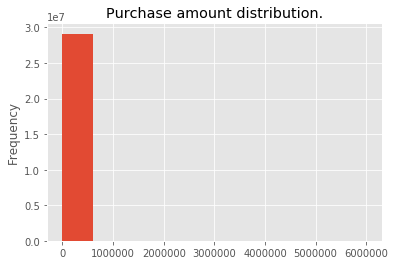

In [150]:
# purchase amount
plt.title('Purchase amount distribution.')
historical_transactions['purchase_amount'].plot(kind='hist');
#plt.hist(historical_transactions['purchase_amount'])
print('purchase_amount max:{0:.5f} min:{1:.5f}'.format(historical_transactions['purchase_amount'].max(), historical_transactions['purchase_amount'].min()))

In [151]:
hist_transac = historical_transactions['purchase_amount']
hist_transac = hist_transac.sort_values()

In [152]:
hist_transac[::-1][11200:11250]

10359386    12.073712
10359391    12.073712
10359352    12.073712
10359345    12.073712
21593763    12.072630
12641037    12.070707
19398214    12.070707
27076716    12.070707
15540712    12.070151
27970610    12.069655
17191915    12.068603
27479307    12.067897
20409234    12.065718
5286775     12.064696
15283879    12.064696
9356313     12.064546
6312519     12.060819
28201121    12.059302
12405512    12.058806
281576      12.056356
29016340    12.056341
21150626    12.055680
5926905     12.055680
26777080    12.055410
28357935    12.054178
15182440    12.052675
17215942    12.052224
16620132    12.050767
23551979    12.048287
24325140    12.047431
24325141    12.047431
7950638     12.046664
7950680     12.046664
4930115     12.042262
28410629    12.041555
10968498    12.040654
5744232     12.040534
5744178     12.040534
16700215    12.039286
28984333    12.038911
20963015    12.038400
28195345    12.034763
16821565    12.034433
16821577    12.034433
26230427    12.033291
3667703   

In [153]:
statistic_pur_amount_dis = [0]*10
for val in hist_transac:
    if val < 0 :
        statistic_pur_amount_dis[0] += 1
    else :
        for i in range(8):
            if val / 10**i < 1:
                statistic_pur_amount_dis[i+1] += 1
                break
statistic_pur_amount_dis

[28036884, 727767, 332786, 13741, 354, 583, 232, 13, 1, 0]

In [154]:
stat_pur_amnt_ID = historical_transactions[['card_id','purchase_amount']]
st = stat_pur_amnt_ID.groupby('card_id')['purchase_amount'].agg(['mean', 'count','sum']).sort_values(by='sum')

# reverse order st
st[::-1][:10]

,mean,count,sum
card_id,,,
C_ID_3b6ac8e52d,500883.004724,12,6.010596e+06
C_ID_5643cd48de,2623.260262,63,1.652654e+05
C_ID_bf460be950,1443.181826,102,1.472045e+05
C_ID_c9a8dc2e32,3290.920431,42,1.382187e+05
C_ID_7d394c4bc0,1086.265457,127,1.379557e+05
C_ID_69317a1c08,304.056095,444,1.350009e+05
C_ID_37f5285802,9625.442965,14,1.347562e+05
C_ID_56cd2cfd99,2503.985592,51,1.277033e+05
C_ID_39f02c4538,286.985650,418,1.199600e+05


In [155]:
train.merge(st,how='inner',on=['card_id']).sort_values(by='sum')[::-1][:10]

,first_active_month,card_id,feature_1,feature_2,feature_3,target,first_active_month_year,first_active_month_weekday,first_active_month_month,elapsed_time,mean,count,sum
74077,2017-04-01,C_ID_3b6ac8e52d,3,1,1,0.072539,2017,5,4,306,500883.004724,12,6.010596e+06
95231,2016-05-01,C_ID_5643cd48de,4,2,0,-0.068451,2016,6,5,641,2623.260262,63,1.652654e+05
79900,2016-03-01,C_ID_bf460be950,5,1,1,1.089207,2016,1,3,702,1443.181826,102,1.472045e+05
34046,2016-11-01,C_ID_c9a8dc2e32,2,2,0,4.892765,2016,1,11,457,3290.920431,42,1.382187e+05
198079,2017-08-01,C_ID_69317a1c08,5,2,1,-0.876824,2017,1,8,184,304.056095,444,1.350009e+05
146004,2017-11-01,C_ID_37f5285802,4,1,0,2.143172,2017,2,11,92,9625.442965,14,1.347562e+05
16487,2016-06-01,C_ID_56cd2cfd99,2,2,0,-0.451464,2016,2,6,610,2503.985592,51,1.277033e+05
173316,2016-09-01,C_ID_39f02c4538,1,2,0,0.751537,2016,3,9,518,286.985650,418,1.199600e+05
138677,2016-12-01,C_ID_a19c81dda8,5,2,1,0.002230,2016,3,12,427,473.420547,253,1.197754e+05
115728,2016-08-01,C_ID_b01eb692ec,2,2,0,-4.615427,2016,0,8,549,315.181434,333,1.049554e+05


In [156]:
historical_transactions.groupby(['installments'])['purchase_amount'].agg(['count','sum','mean'])

,count,sum,mean
installments,,,
-1,178159,1.041286e+04,0.058447
0,15411747,5.577912e+06,0.361926
1,11677522,-4.724214e+06,-0.404556
2,666416,-2.466169e+05,-0.370065
3,538207,-5.537652e+04,-0.102891
4,179525,3.575004e+04,0.199137
5,116090,4.101962e+04,0.353343
6,132634,9.239147e+04,0.696590
7,10906,7.206487e+03,0.660782


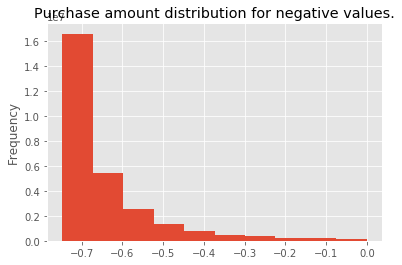

In [157]:
plt.title('Purchase amount distribution for negative values.');
historical_transactions.loc[historical_transactions['purchase_amount'] < 0, 'purchase_amount'].plot(kind='hist');

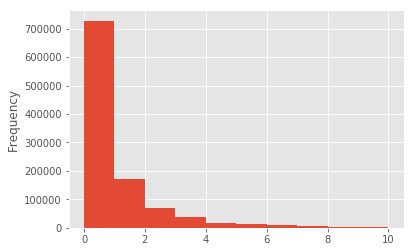

In [158]:
historical_transactions.loc[(historical_transactions['purchase_amount'] >= 0)&(historical_transactions['purchase_amount'] <= 10), 'purchase_amount'].plot(kind='hist');

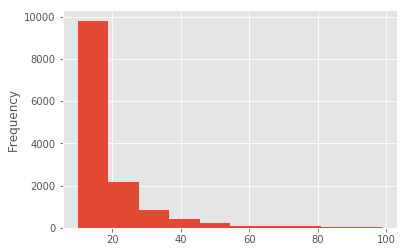

In [159]:
historical_transactions.loc[(historical_transactions['purchase_amount'] >= 10)&(historical_transactions['purchase_amount'] <= 100), 'purchase_amount'].plot(kind='hist');

In [160]:
#Categories

map_dict = {'Y': 0, 'N': 1}
historical_transactions['category_1'] = historical_transactions['category_1'].apply(lambda x: map_dict[x])
historical_transactions.groupby(['category_1']).agg({'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag': ['mean', 'std']})

authorized_flag           purchase_amount                       
                      mean       std            mean          std     count
category_1                                                                 
0                 0.748578  0.433830       -0.419327    22.087594   2084029
1                 0.926265  0.261339        0.071540  1166.016045  27028332

In [161]:
historical_transactions.groupby(['category_2']).agg({'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag': ['mean', 'std']})

authorized_flag           purchase_amount                       
                      mean       std            mean          std     count
category_2                                                                 
1.0               0.927505  0.259306        0.149570  1548.714128  15177199
2.0               0.906225  0.291515       -0.165690    89.285770   1026535
3.0               0.918857  0.273055        0.180375   210.616100   3911795
4.0               0.927634  0.259094       -0.158951   141.945606   2618053
5.0               0.934260  0.247826       -0.104457   162.428785   3725915

In [162]:
map_dict = {'A': 0, 'B': 1, 'C': 2, 'nan': 3}
historical_transactions['category_3'] = historical_transactions['category_3'].apply(lambda x: map_dict[str(x)])
historical_transactions.groupby(['category_3']).agg({'purchase_amount': ['mean', 'std', 'count'], 'authorized_flag': ['mean', 'std']})

authorized_flag           purchase_amount                       
                      mean       std            mean          std     count
category_3                                                                 
0                 0.928032  0.258436        0.361926  1541.485188  15411747
1                 0.907024  0.290399       -0.404556   104.062692  11677522
2                 0.836498  0.369824        0.106023    24.047655   1844933
3                 0.885692  0.318186        0.058447     2.191567    178159

In [163]:
for col in ['city_id', 'merchant_category_id', 'merchant_id', 'state_id', 'subsector_id']:
    print("There are {0} unique values in {1}.".format(historical_transactions[col].nunique(),col))

There are 308 unique values in city_id.
There are 327 unique values in merchant_category_id.
There are 326311 unique values in merchant_id.
There are 25 unique values in state_id.
There are 41 unique values in subsector_id.


In [164]:
#Feature engineering

def aggregate_historical_transactions(trans, prefix):
    trans['purchase_month'] = trans['purchase_date'].dt.month
    trans['installments'] = trans['installments'].astype(int)
    trans['month_diff'] = ((datetime.datetime.today() - trans['purchase_date']).dt.days)//30
    trans['month_diff'] += trans['month_lag']
    trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']). \
                                        astype(np.int64) * 1e-9
    trans = pd.get_dummies(trans, columns=['category_2', 'category_3'])
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean', 'sum'],
        'category_2_2.0': ['mean', 'sum'],
        'category_2_3.0': ['mean', 'sum'],
        'category_2_4.0': ['mean', 'sum'],
        'category_2_5.0': ['mean', 'sum'],
        'category_3_1': ['sum', 'mean'],
        'category_3_2': ['sum', 'mean'],
        'category_3_3': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'max', 'min'],
        'month_lag': ['min', 'max'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique'],
        'city_id': ['nunique'],
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))

    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')

    return agg_trans

In [165]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])
    history['installments'] = history['installments'].astype(int)
    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

final_group = aggregate_per_month(historical_transactions) 

In [166]:
%%time
historical_transactions = reduce_mem_usage(historical_transactions)
history = aggregate_historical_transactions(historical_transactions, prefix='hist_')

train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')
print(train.shape[0],test.shape[0])


Mem. usage decreased to 1166.08 Mb (62.5% reduction)
201917 123623
CPU times: user 1min 29s, sys: 9.39 s, total: 1min 38s
Wall time: 1min 38s


In [167]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,first_active_month_year,first_active_month_weekday,first_active_month_month,elapsed_time,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_subsector_id_nunique,hist_category_3_3_sum,hist_category_3_3_mean,hist_category_3_1_sum,hist_category_3_1_mean,hist_merchant_category_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_category_2_5.0_mean,hist_category_2_5.0_sum,hist_purchase_date_ptp,hist_purchase_date_max,hist_purchase_date_min,hist_category_2_4.0_mean,hist_category_2_4.0_sum,hist_category_2_2.0_mean,hist_category_2_2.0_sum,hist_merchant_id_nunique,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_category_2_3.0_mean,hist_category_2_3.0_sum,hist_month_lag_min,hist_month_lag_max,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_city_id_nunique,hist_category_2_1.0_mean,hist_category_2_1.0_sum,hist_state_id_nunique,hist_category_1_sum,hist_category_1_mean,hist_category_3_2_sum,hist_category_3_2_mean
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,2017,5,4,306,68,44.0,0.647059,12,0,0.000000,46.0,0.676471,16,-40.733734,-0.599025,0.235676,-0.743903,0.192268,0.000000,0.0,23179380.0,1.514510e+09,1.491330e+09,0.000000,0.0,0.0,0.0,24,141,2.073529,12,1,2.061127,0.000000,0.0,-8,0,8.367647,12,4,2.454994,7,0.661765,45.0,3,45.0,0.661765,22.0,0.323529
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,2017,6,1,396,78,77.0,0.987179,12,0,0.000000,76.0,0.974359,16,-49.136513,-0.629955,0.318817,-0.731881,0.154999,0.000000,0.0,34667913.0,1.518989e+09,1.484321e+09,0.961538,75.0,0.0,0.0,27,83,1.064103,4,1,0.405794,0.012821,1.0,-13,0,3.282051,5,1,1.357016,4,0.000000,0.0,3,76.0,0.974359,2.0,0.025641
2,2017-08-01,C_ID_b709037bc5,5,1,1,2017,1,8,184,13,9.0,0.692308,6,3,0.230769,1.0,0.076923,8,4.528841,0.348372,2.525867,-0.536537,0.906547,0.846154,11.0,13924886.0,1.517598e+09,1.503673e+09,0.000000,0.0,0.0,0.0,9,44,3.384615,10,-1,3.686427,0.000000,0.0,-6,0,7.307692,12,1,4.819831,4,0.076923,1.0,4,12.0,0.923077,9.0,0.692308
3,2017-12-01,C_ID_d27d835a9f,2,1,0,2017,4,12,62,26,26.0,1.000000,11,2,0.076923,17.0,0.653846,18,-13.690715,-0.526566,0.087965,-0.731881,0.219162,0.000000,0.0,6734846.0,1.519127e+09,1.512392e+09,0.000000,0.0,0.0,0.0,23,38,1.461538,6,-1,1.475961,0.000000,0.0,-2,0,7.692308,12,1,5.136296,1,1.000000,26.0,1,26.0,1.000000,7.0,0.269231
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,2015,1,12,793,110,87.0,0.790909,15,0,0.000000,104.0,0.945455,31,25.139385,0.228540,15.782255,-0.746758,2.777764,0.000000,0.0,36283897.0,1.519728e+09,1.483444e+09,0.918182,101.0,0.0,0.0,47,120,1.090909,4,1,0.439880,0.045455,5.0,-13,0,4.827273,12,1,3.361572,5,0.036364,4.0,4,110.0,1.000000,6.0,0.054545


In [168]:
del d1, d2, authorized_card_rate
del history
del historical_transactions
gc.collect()

16405

In [169]:
# new_merchant_transactions

new_merchant_transactions = pd.read_csv('./input/new_merchant_transactions.csv')
e = pd.read_excel('./input/Data_Dictionary.xlsx', sheet_name='new_merchant_period')
e

,new_merchant_period.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,card_id,Card identifier
3,month_lag,month lag to reference date
4,purchase_date,Purchase date
5,authorized_flag,"Y' if approved, 'N' if denied"
6,category_3,anonymized category
7,installments,number of installments of purchase
8,category_1,anonymized category
9,merchant_category_id,Merchant category identifier (anonymized )


In [170]:
print('{0} samples in data'.format(new_merchant_transactions.shape[0]))
new_merchant_transactions.head()


1963031 samples in data


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [171]:
new_installments999 = new_merchant_transactions.loc[(new_merchant_transactions['installments'] == 999) & (new_merchant_transactions['category_3'].astype(str) != 'C')]
#his_installments999 = new_merchant_transactions.loc[(new_merchant_transactions['installments'] == -1) & (new_merchant_transactions['category_3'].notnull())]

new_installments999

# installments     cate3
#     NaN           -1
#     0             A
#     1             B
#   others          C

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id


In [172]:
# let's convert the authorized_flag to a binary value.
new_merchant_transactions['authorized_flag'] = new_merchant_transactions['authorized_flag'].apply(lambda x: 1 if x == 'Y' else 0)

At average 100.0000% transactions are authorized


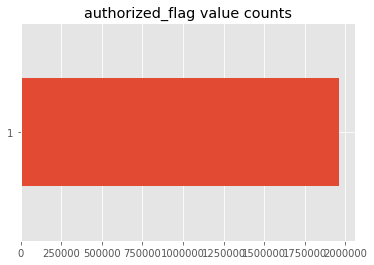

In [173]:
print("At average {0:.4f}% transactions are authorized".format(new_merchant_transactions['authorized_flag'].mean() * 100))
new_merchant_transactions['authorized_flag'].value_counts().plot(kind='barh', title='authorized_flag value counts');

In [174]:
card_total_purchase = new_merchant_transactions.groupby(['card_id'])['purchase_amount'].sum().sort_values()
card_total_purchase.head()

card_id
C_ID_b7ebee6539   -70.813489
C_ID_8946508722   -63.907274
C_ID_c729288535   -61.042650
C_ID_6cef1dba4b   -60.780407
C_ID_0e4f6af077   -60.017000
Name: purchase_amount, dtype: float64

In [175]:
card_total_purchase.tail()

card_id
C_ID_72613043cf    109.086210
C_ID_01314ceccf    113.317420
C_ID_a9435eee72    145.168997
C_ID_a289e7edd4    172.182653
C_ID_ca850ecf25    263.157498
Name: purchase_amount, dtype: float64

In [176]:
new_merchant_transactions['installments'].value_counts()

 0      922244
 1      836178
-1       55922
 2       54729
 3       44750
 4       14815
 6       10389
 5        9296
 10       8899
 12       2850
 8        1555
 7         863
 9         478
 11         61
 999         2
Name: installments, dtype: int64

In [177]:
new_merchant_transactions.groupby(['installments'])['purchase_amount'].agg(['count','sum','mean'])

,count,sum,mean
installments,,,
-1,55922,1903.176718,0.034033
0,922244,-581948.746520,-0.631014
1,836178,-507130.345871,-0.606486
2,54729,-21592.186709,-0.394529
3,44750,-6669.938153,-0.149049
4,14815,3212.909351,0.216869
5,9296,2641.835005,0.284191
6,10389,6994.802878,0.673289
7,863,522.470989,0.605413


In [178]:
new_merchant_transactions['installments'] = new_merchant_transactions['installments'].astype('category')

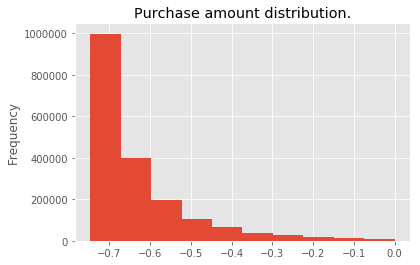

In [179]:
# new purchase_amount

plt.title('Purchase amount distribution.');
new_merchant_transactions.loc[new_merchant_transactions['purchase_amount'] < 0, 'purchase_amount'].plot(kind='hist');

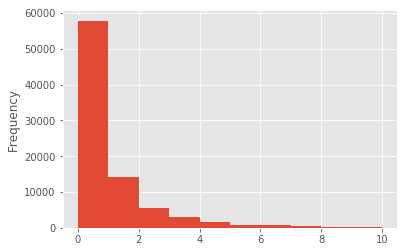

In [180]:
new_merchant_transactions.loc[(new_merchant_transactions['purchase_amount'] >= 0)&(new_merchant_transactions['purchase_amount'] <= 10), 'purchase_amount'].plot(kind='hist');

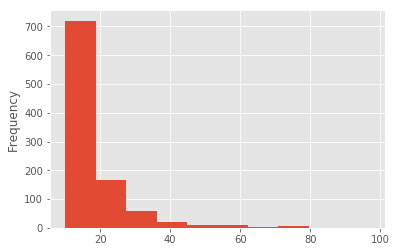

In [181]:
new_merchant_transactions.loc[(new_merchant_transactions['purchase_amount'] >= 10)&(new_merchant_transactions['purchase_amount'] <= 100), 'purchase_amount'].plot(kind='hist');

In [182]:
hist_transac = new_merchant_transactions['purchase_amount']
hist_transac = hist_transac.sort_values()

In [183]:
statistic_pur_amount_dis = [0]*10
for val in hist_transac:
    if val < 0 :
        statistic_pur_amount_dis[0] += 1
    else :
        for i in range(8):
            if val / 10**i < 1:
                statistic_pur_amount_dis[i+1] += 1
                break
statistic_pur_amount_dis

[1877357, 57875, 26803, 994, 2, 0, 0, 0, 0, 0]

In [184]:
hist_transac

94099       -0.746893
230985      -0.746893
362616      -0.746893
1806995     -0.746893
1461975     -0.746893
1553942     -0.746893
1128037     -0.746893
1335337     -0.746893
1955832     -0.746893
1402507     -0.746893
1552866     -0.746893
1409886     -0.746893
327519      -0.746893
1209674     -0.746893
1922239     -0.746893
792008      -0.746893
67991       -0.746893
498710      -0.746893
1618669     -0.746893
1359409     -0.746893
521233      -0.746893
380568      -0.746893
179855      -0.746893
1847930     -0.746893
792210      -0.746893
1332509     -0.746893
1407544     -0.746893
792803      -0.746893
389728      -0.746893
1418506     -0.746893
              ...    
695641      49.282361
218541      50.038945
1225647     50.091042
1148235     50.642410
147056      50.944293
1250625     51.845883
1258120     52.098329
946033      52.893832
903974      52.923284
1540922     54.367332
669769      55.998159
1608570     57.097649
1007576     59.208874
898125      59.359139
81110     

In [185]:
for i in [0, 10, 100]:
    n = new_merchant_transactions.loc[new_merchant_transactions['purchase_amount'] > i].shape[0]
    print("There are {0} transactions with purchase_amount more than {1}.".format(n,i))

There are 85674 transactions with purchase_amount more than 0.
There are 996 transactions with purchase_amount more than 10.
There are 2 transactions with purchase_amount more than 100.


In [186]:
# Categories
map_dict = {'Y': 0, 'N': 1}
new_merchant_transactions['category_1'] = new_merchant_transactions['category_1'].apply(lambda x: map_dict[x])
new_merchant_transactions.groupby(['category_1']).agg({'purchase_amount': ['mean', 'std', 'count']})

purchase_amount                   
                      mean       std    count
category_1                                   
0                -0.218671  1.481696    63096
1                -0.562004  0.648799  1899935

In [187]:
new_merchant_transactions.groupby(['category_2']).agg({'purchase_amount': ['mean', 'std', 'count']})

purchase_amount                   
                      mean       std    count
category_2                                   
1.0              -0.569242  0.673693  1058242
2.0              -0.555640  0.542029    65663
3.0              -0.550852  0.612882   289525
4.0              -0.557578  0.600636   178590
5.0              -0.549015  0.654138   259266

In [188]:
map_dict = {'A': 0, 'B': 1, 'C': 2, 'nan': 3}
new_merchant_transactions['category_3'] = new_merchant_transactions['category_3'].apply(lambda x: map_dict[str(x)])
new_merchant_transactions.groupby(['category_3']).agg({'purchase_amount': ['mean', 'std', 'count']})

purchase_amount                  
                      mean       std   count
category_3                                  
0                -0.631014  0.268039  922244
1                -0.606486  0.443664  836178
2                 0.037708  1.787946  148687
3                 0.034033  1.692377   55922

In [189]:
for col in ['city_id', 'merchant_category_id', 'merchant_id', 'state_id', 'subsector_id']:
    print("There are {0} unique values in {1}.".format(new_merchant_transactions[col].nunique(),col))

There are 308 unique values in city_id.
There are 314 unique values in merchant_category_id.
There are 226129 unique values in merchant_id.
There are 25 unique values in state_id.
There are 41 unique values in subsector_id.


In [190]:
new_merchant_transactions['purchase_date'] = pd.to_datetime(new_merchant_transactions['purchase_date'])

In [191]:
# Feature engineering

def aggregate_historical_transactions(trans, prefix):
    trans['purchase_month'] = trans['purchase_date'].dt.month
    trans['month_diff'] = ((datetime.datetime.today() - trans['purchase_date']).dt.days)//30
    trans['month_diff'] += trans['month_lag']
    trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']).astype(np.int64) * 1e-9
    trans['installments'] = trans['installments'].astype(int)
    trans = pd.get_dummies(trans, columns=['category_2', 'category_3'])
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean', 'sum'],
        'category_2_2.0': ['mean', 'sum'],
        'category_2_3.0': ['mean', 'sum'],
        'category_2_4.0': ['mean', 'sum'],
        'category_2_5.0': ['mean', 'sum'],
        'category_3_1': ['sum', 'mean'],
        'category_3_2': ['sum', 'mean'],
        'category_3_3': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'max', 'min'],
        'month_lag': ['min', 'max'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique'],
        'city_id': ['nunique'],
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))

    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')

    return agg_trans

In [192]:
%%time
gc.collect()
new_transactions = reduce_mem_usage(new_merchant_transactions)
history = aggregate_historical_transactions(new_merchant_transactions, prefix='new')


del new_merchant_transactions
gc.collect()

train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')
del history
gc.collect()

Mem. usage decreased to 73.01 Mb (62.9% reduction)
CPU times: user 27.6 s, sys: 157 ms, total: 27.7 s
Wall time: 27.8 s


In [193]:
train = pd.merge(train, final_group, on='card_id')
test = pd.merge(test, final_group, on='card_id')


gc.collect()
del final_group

In [194]:
# merchants

merchants = pd.read_csv('./input/merchants.csv')
e = pd.read_excel('./input/Data_Dictionary.xlsx', sheet_name='merchant')
e

,merchants.csv,Unnamed: 1
0,NaN,NaN
1,Columns,Description
2,merchant_id,Unique merchant identifier
3,merchant_group_id,Merchant group (anonymized )
4,merchant_category_id,Unique identifier for merchant category (anonymized )
5,subsector_id,Merchant category group (anonymized )
6,numerical_1,anonymized measure
7,numerical_2,anonymized measure
8,category_1,anonymized category
9,most_recent_sales_range,Range of revenue (monetary units) in last active month --> A > B > C > D > E


In [195]:
print('{0} merchants in data'.format(merchants.shape[0]))
merchants.head()

334696 merchants in data


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [196]:
# encoding categories.
map_dict = {'Y': 0, 'N': 1}
merchants['category_1'] = merchants['category_1'].apply(lambda x: map_dict[x])
merchants.loc[merchants['category_2'].isnull(), 'category_2'] = 0
merchants['category_4'] = merchants['category_4'].apply(lambda x: map_dict[x])

In [197]:
merchants['merchant_category_id'].nunique(), merchants['merchant_group_id'].nunique()

(324, 109391)

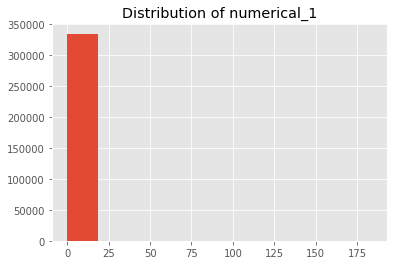

In [198]:
# numerical_1

plt.hist(merchants['numerical_1']);
plt.title('Distribution of numerical_1');

In [199]:
np.percentile(merchants['numerical_1'], 95)

0.09125291

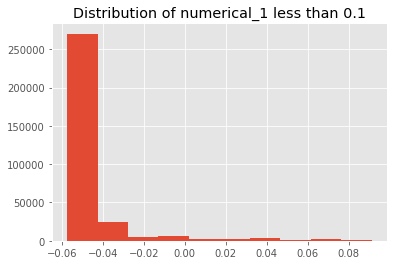

In [200]:
plt.hist(merchants.loc[merchants['numerical_1'] < 0.1, 'numerical_1']);
plt.title('Distribution of numerical_1 less than 0.1');

In [201]:
min_n1 = merchants['numerical_1'].min()
_ = sum(merchants['numerical_1'] == min_n1) / merchants['numerical_1'].shape[0]
print('{0:.4f}% of values in numerical_1 are equal to {1}'.format(_ * 100,min_n1))

68.3570% of values in numerical_1 are equal to -0.05747065


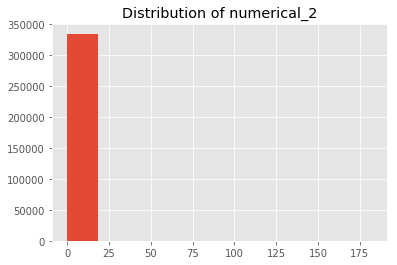

In [202]:
# Numerical_2

plt.hist(merchants['numerical_2']);
plt.title('Distribution of numerical_2');

74.3104% of values in numerical_1 are equal to -0.05747065


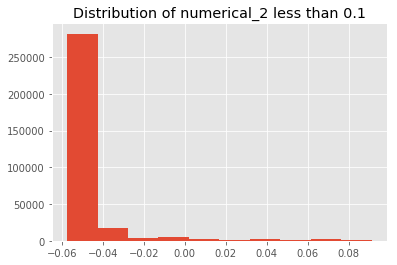

In [203]:
plt.hist(merchants.loc[merchants['numerical_2'] < 0.1, 'numerical_2']);
plt.title('Distribution of numerical_2 less than 0.1');
min_n2 = merchants['numerical_2'].min()
_ = sum(merchants['numerical_2'] == min_n2) / merchants['numerical_2'].shape[0]
print('{0:.4f}% of values in numerical_1 are equal to {1}'.format(_ * 100,min_n2))

In [204]:
(merchants['numerical_1'] != merchants['numerical_2']).sum() / merchants.shape[0]

0.10056289886942181

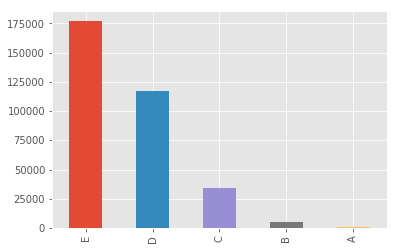

In [205]:
# most_recent_sales_range

merchants['most_recent_sales_range'].value_counts().plot('bar')

In [206]:
d = merchants['most_recent_sales_range'].value_counts().sort_index()
e = merchants.loc[merchants['numerical_2'] < 0.1].groupby('most_recent_sales_range')['numerical_1'].mean()
data = [go.Bar(x=d.index, y=d.values, name='counts'), go.Scatter(x=e.index, y=e.values, name='mean numerical_1', yaxis='y2')]
layout = go.Layout(dict(title = "Counts of values in categories of most_recent_sales_range",
                        xaxis = dict(title = 'most_recent_sales_range'),
                        yaxis = dict(title = 'Counts'),
                        yaxis2=dict(title='mean numerical_1', overlaying='y', side='right')),
                   legend=dict(orientation="v"))
py.iplot(dict(data=data, layout=layout))

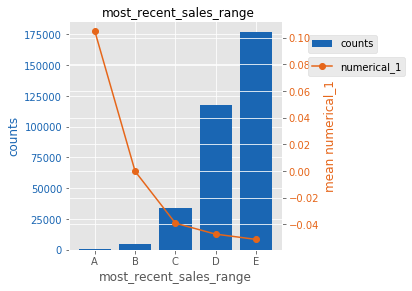

In [207]:
d = merchants['most_recent_sales_range'].value_counts().sort_index()
e = merchants.loc[merchants['numerical_2'] < 0.1].groupby('most_recent_sales_range')['numerical_1'].mean()

# plot with various axes scales

fig, ax1 = plt.subplots()
fig.suptitle('most_recent_sales_range',x=0.42,y=1)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color_counts = (0.1 , 0.4 , 0.7)

ax1.set_xlabel('most_recent_sales_range')
ax1.set_ylabel('counts', color=color_counts)

ax1.tick_params(axis='y', labelcolor=color_counts)

ax1.bar(d.index, d.values,color=color_counts, label = 'counts')
ax1.legend(loc=6, bbox_to_anchor=(1.1, 0.9), ncol=2)

color_num_1 = (0.9 , 0.4 , 0.1)
ax2.set_ylabel('mean numerical_1', color=color_num_1)  # we already handled the x-label with ax1

ax2.tick_params(axis='y', labelcolor=color_num_1)

ax2.plot(e, '-o',color=color_num_1)
#ax2.scatter(e.index, e.values)
ax2.legend(loc=6, bbox_to_anchor=(1.1, 0.8), ncol=2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

#print('train max month:{0},counts:{1}'.format(d1.argmax(0), d1.max()))
#print('test max month:{0},counts:{1}'.format(d2.argmax(0), d2.max()))

In [208]:
# most_recent_purchases_range

d = merchants['most_recent_purchases_range'].value_counts().sort_index()
e = merchants.loc[merchants['numerical_2'] < 0.1].groupby('most_recent_purchases_range')['numerical_1'].mean()
data = [go.Bar(x=d.index, y=d.values, name='counts'), go.Scatter(x=e.index, y=e.values, name='mean numerical_1', yaxis='y2')]
layout = go.Layout(dict(title = "Counts of values in categories of most_recent_purchases_range",
                        xaxis = dict(title = 'most_recent_purchases_range'),
                        yaxis = dict(title = 'Counts'),
                        yaxis2=dict(title='mean numerical_1', overlaying='y', side='right')),
                   legend=dict(orientation="v"))
py.iplot(dict(data=data, layout=layout))

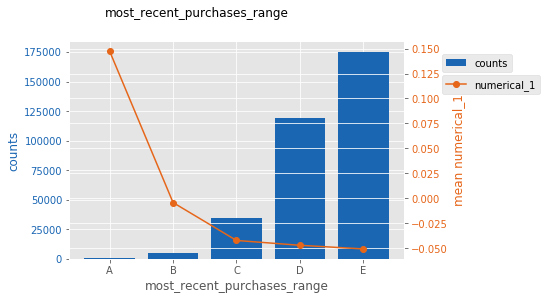

In [209]:
d = merchants['most_recent_purchases_range'].value_counts().sort_index()
e = merchants.loc[merchants['numerical_2'] < 0.1].groupby('most_recent_purchases_range')['numerical_1'].mean()

# plot with various axes scales

fig, ax1 = plt.subplots()
fig.suptitle('most_recent_purchases_range',x=0.42,y=1)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color_counts = (0.1 , 0.4 , 0.7)

ax1.set_xlabel('most_recent_purchases_range')
ax1.set_ylabel('counts', color=color_counts)

ax1.tick_params(axis='y', labelcolor=color_counts)

ax1.bar(d.index, d.values,color=color_counts, label = 'counts')
ax1.legend(loc=6, bbox_to_anchor=(1.1, 0.9), ncol=2)

color_num_1 = (0.9 , 0.4 , 0.1)
ax2.set_ylabel('mean numerical_1', color=color_num_1)  # we already handled the x-label with ax1

ax2.tick_params(axis='y', labelcolor=color_num_1)

ax2.plot(e, '-o',color=color_num_1)
#ax2.scatter(e.index, e.values)
ax2.legend(loc=6, bbox_to_anchor=(1.1, 0.8), ncol=2)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

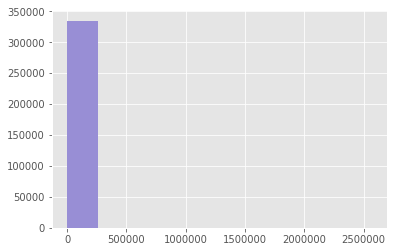

In [210]:
# avg_sales_lag

plt.hist(merchants['avg_sales_lag3'].fillna(0));
plt.hist(merchants['avg_sales_lag6'].fillna(0));
plt.hist(merchants['avg_sales_lag12'].fillna(0));


In [211]:
for col in ['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12']:
    print('Max value of {0} is {1}'.format(col, merchants[col].max()))
    print('Min value of {0} is {1}'.format(col, merchants[col].min()))

Max value of avg_sales_lag3 is 851844.64
Min value of avg_sales_lag3 is -82.13
Max value of avg_sales_lag6 is 1513959.0
Min value of avg_sales_lag6 is -82.13
Max value of avg_sales_lag12 is 2567408.0
Min value of avg_sales_lag12 is -82.13


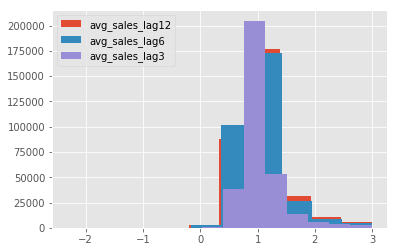

In [212]:
plt.hist(merchants.loc[(merchants['avg_sales_lag12'] < 3) & (merchants['avg_sales_lag12'] > -10), 'avg_sales_lag12'].fillna(0), label='avg_sales_lag12');
plt.hist(merchants.loc[(merchants['avg_sales_lag6'] < 3) & (merchants['avg_sales_lag6'] > -10), 'avg_sales_lag6'].fillna(0), label='avg_sales_lag6');
plt.hist(merchants.loc[(merchants['avg_sales_lag3'] < 3) & (merchants['avg_sales_lag3'] > -10), 'avg_sales_lag3'].fillna(0), label='avg_sales_lag3');
plt.legend();

In [213]:
# avg_purchases_lag
merchants['avg_purchases_lag3'].nlargest()

10                inf
11                inf
12                inf
235      6.185133e+04
13168    1.730000e+03
Name: avg_purchases_lag3, dtype: float64

In [214]:
merchants.loc[merchants['avg_purchases_lag3'] == np.inf, 'avg_purchases_lag3'] = 6000
merchants.loc[merchants['avg_purchases_lag6'] == np.inf, 'avg_purchases_lag6'] = 6000
merchants.loc[merchants['avg_purchases_lag12'] == np.inf, 'avg_purchases_lag12'] = 6000


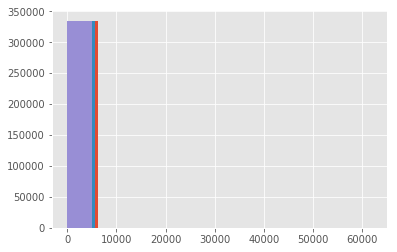

In [215]:
plt.hist(merchants['avg_purchases_lag3'].fillna(0));
plt.hist(merchants['avg_purchases_lag6'].fillna(0));
plt.hist(merchants['avg_purchases_lag12'].fillna(0));

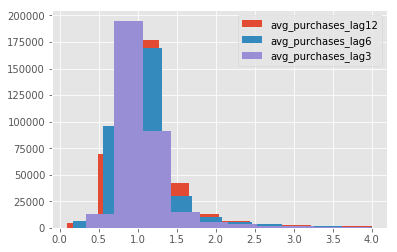

In [216]:
plt.hist(merchants.loc[(merchants['avg_purchases_lag12'] < 4), 'avg_purchases_lag12'].fillna(0), label='avg_purchases_lag12');
plt.hist(merchants.loc[(merchants['avg_purchases_lag6'] < 4), 'avg_purchases_lag6'].fillna(0), label='avg_purchases_lag6');
plt.hist(merchants.loc[(merchants['avg_purchases_lag3'] < 4), 'avg_purchases_lag3'].fillna(0), label='avg_purchases_lag3');
plt.legend();

In [217]:
# Processing data for modelling
train.head()
print(train.shape[0],test.shape[0])

201917 123623


In [218]:
for col in train.columns:
    if train[col].isna().any():
        train[col] = train[col].fillna(0)

In [219]:
for col in test.columns:
    if test[col].isna().any():
        test[col] = test[col].fillna(0)

In [220]:
train_subID = train['card_id'].loc[(train['target'] > -4)& (train['target'] < 4)]
train_subID = pd.DataFrame({'card_id':train_subID.values})
#train_subID.head()
train_sub = train
train_sub = train_sub.merge(train_subID,on=['card_id'])
train_sub.head()

print('train shape:{0},train_sub shape:{1}'.format(train.shape,train_sub.shape))

train shape:(201917, 124),train_sub shape:(191951, 124)


In [221]:
y = train['target']
y1 = train_sub['target']

In [222]:
col_to_drop = ['first_active_month', 'card_id', 'target']

In [224]:
for col in col_to_drop:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)
    if col in train_sub.columns:
        train_sub.drop([col], axis=1, inplace=True)

In [225]:
train['feature_3'] = train['feature_3'].astype(int)
test['feature_3'] = test['feature_3'].astype(int)
train_sub['feature_3'] = train_sub['feature_3'].astype(int)

In [226]:
categorical_feats = ['feature_1', 'feature_2']

for col in categorical_feats:
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))
    
    train_sub[col] = lbl.transform(list(train_sub[col].values.astype('str')))

In [227]:
train.head()

,feature_1,feature_2,feature_3,first_active_month_year,first_active_month_weekday,first_active_month_month,elapsed_time,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_subsector_id_nunique,hist_category_3_3_sum,hist_category_3_3_mean,hist_category_3_1_sum,hist_category_3_1_mean,hist_merchant_category_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_category_2_5.0_mean,hist_category_2_5.0_sum,hist_purchase_date_ptp,hist_purchase_date_max,hist_purchase_date_min,hist_category_2_4.0_mean,hist_category_2_4.0_sum,hist_category_2_2.0_mean,hist_category_2_2.0_sum,hist_merchant_id_nunique,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_category_2_3.0_mean,hist_category_2_3.0_sum,hist_month_lag_min,hist_month_lag_max,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_city_id_nunique,hist_category_2_1.0_mean,hist_category_2_1.0_sum,hist_state_id_nunique,hist_category_1_sum,hist_category_1_mean,hist_category_3_2_sum,hist_category_3_2_mean,newtransactions_count,newmonth_lag_min,newmonth_lag_max,newsubsector_id_nunique,newcategory_3_3_sum,newcategory_3_3_mean,newcategory_3_1_sum,newcategory_3_1_mean,newmerchant_category_id_nunique,newpurchase_amount_sum,newpurchase_amount_mean,newpurchase_amount_max,newpurchase_amount_min,newpurchase_amount_std,newcategory_2_5.0_mean,newcategory_2_5.0_sum,newpurchase_date_ptp,newpurchase_date_max,newpurchase_date_min,newcategory_2_4.0_mean,newcategory_2_4.0_sum,newcategory_2_2.0_mean,newcategory_2_2.0_sum,newmerchant_id_nunique,newinstallments_sum,newinstallments_mean,newinstallments_max,newinstallments_min,newinstallments_std,newcategory_2_3.0_mean,newcategory_2_3.0_sum,newcity_id_nunique,newpurchase_month_mean,newpurchase_month_max,newpurchase_month_min,newpurchase_month_std,newcategory_2_1.0_mean,newcategory_2_1.0_sum,newstate_id_nunique,newcategory_1_sum,newcategory_1_mean,newcategory_3_2_sum,newcategory_3_2_mean,month_lag_mean,month_lag_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std
0,4,1,1,2017,3,6,245,260,247.0,0.950000,21,0,0.000000,4.0,0.015385,41,-165.968735,-0.638341,2.258394,-0.739395,0.212139,0.011538,3.0,20977987.0,1.519551e+09,1.498573e+09,0.000000,0.0,0.0,0.0,94,4,0.015385,1,0,0.123314,0.0,0.0,-8,0,8.057692,12,1,3.474193,7,0.988462,257.0,3,260.0,1.000000,0.0,0.000000,23.0,1.0,2.0,10.0,0.0,0.000000,0.0,0.000000,14.0,-13.242188,-0.575684,-0.296143,-0.724609,0.135742,0.0,0.0,4742309.0,1.525001e+09,1.520259e+09,0.000000,0.0,0.0,0.0,23.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,3.0,3.478261,4.0,3.0,0.510754,1.000000,23.0,1.0,23.0,1.000000,0.0,0.000000,-4.000000,2.738613,28.888889,17.244162,0.444444,0.726483,0.018182,0.032221,0.000000,0.000000,0.333333,0.500000,0.074290,0.117067,28.888889,17.244162,-18.440971,10.472169,-0.650518,0.049922,-0.732686,0.008797,-0.158815,0.916015,0.109641,0.117152
1,3,0,0,2017,6,1,396,350,339.0,0.968571,24,2,0.005714,276.0,0.788571,57,-210.006332,-0.600018,4.630300,-0.742400,0.384967,0.000000,0.0,33717687.0,1.517438e+09,1.483720e+09,0.000000,0.0,0.0,0.0,142,543,1.551429,10,-1,1.510777,0.0,0.0,-12,0,6.220000,12,1,3.848142,9,0.911429,319.0,3,319.0,0.911429,72.0,0.205714,6.0,1.0,2.0,4.0,0.0,0.000000,6.0,1.000000,5.0,-4.355469,-0.726074,-0.701660,-0.739258,0.014381,0.0,0.0,4887632.0,1.522393e+09,1.517505e+09,0.000000,0.0

In [228]:
for col in ['newpurchase_amount_max', 'newpurchase_date_max', 'purchase_amount_max_mean']:
    train[col + '_to_mean'] = train[col] / train[col].mean()
    test[col + '_to_mean'] = test[col] / test[col].mean()
    train_sub[col + '_to_mean'] = train_sub[col] / train_sub[col].mean()

In [229]:
##################
### BGM
##################

In [230]:

X = train
X_test = test
X_sub = train_sub

In [231]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)


In [239]:
def train_model(X=X, X_test=X_test, y=y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            
        if model_type == 'rcv':
            model = RidgeCV(alphas=(0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=3)
            model.fit(X_train, y_train)
            print(model.alpha_)

            y_pred_valid = model.predict(X_valid)
            score = mean_squared_error(y_valid, y_pred_valid) ** 0.5
            print('Fold {0}. RMSE: {1:.4f}.'.format(fold_n,score))
            print('')
            
            y_pred = model.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='RMSE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction


In [117]:
params = {'num_leaves': 54,
         'min_data_in_leaf': 79,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.018545526395058548,
         "boosting": "gbdt",
         "feature_fraction": 0.8354507676881442,
         "bagging_freq": 3,
         "bagging_fraction": 0.8126672064208567,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         'min_child_weight': 5.343384366323818,
         'reg_alpha': 1.1302650970728192,
         'reg_lambda': 0.3603427518866501,
         'subsample': 0.8767547959893627,}

In [240]:
params = {'num_leaves': 100,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': 6,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
#         'device': 'gpu',
#         'gpu_platform_id': 0,
#         'gpu_device_id': 0
        }

Fold 0 started at Wed Dec 19 16:33:28 2018
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 3.53725	valid_1's rmse: 3.71517
[2000]	training's rmse: 3.45748	valid_1's rmse: 3.71013
Early stopping, best iteration is:
[2317]	training's rmse: 3.43652	valid_1's rmse: 3.70955
Fold 1 started at Wed Dec 19 16:34:13 2018
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 3.55262	valid_1's rmse: 3.64343
[2000]	training's rmse: 3.47136	valid_1's rmse: 3.63578
[3000]	training's rmse: 3.40623	valid_1's rmse: 3.63348
[4000]	training's rmse: 3.34989	valid_1's rmse: 3.63269
Early stopping, best iteration is:
[3829]	training's rmse: 3.3592	valid_1's rmse: 3.63263
Fold 2 started at Wed Dec 19 16:35:24 2018
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 3.54812	valid_1's rmse: 3.68851
[2000]	training's rmse: 3.46658	valid_1's rmse: 3.67982
[3000]	training's rmse: 3.39975	valid_1's rmse: 3.677

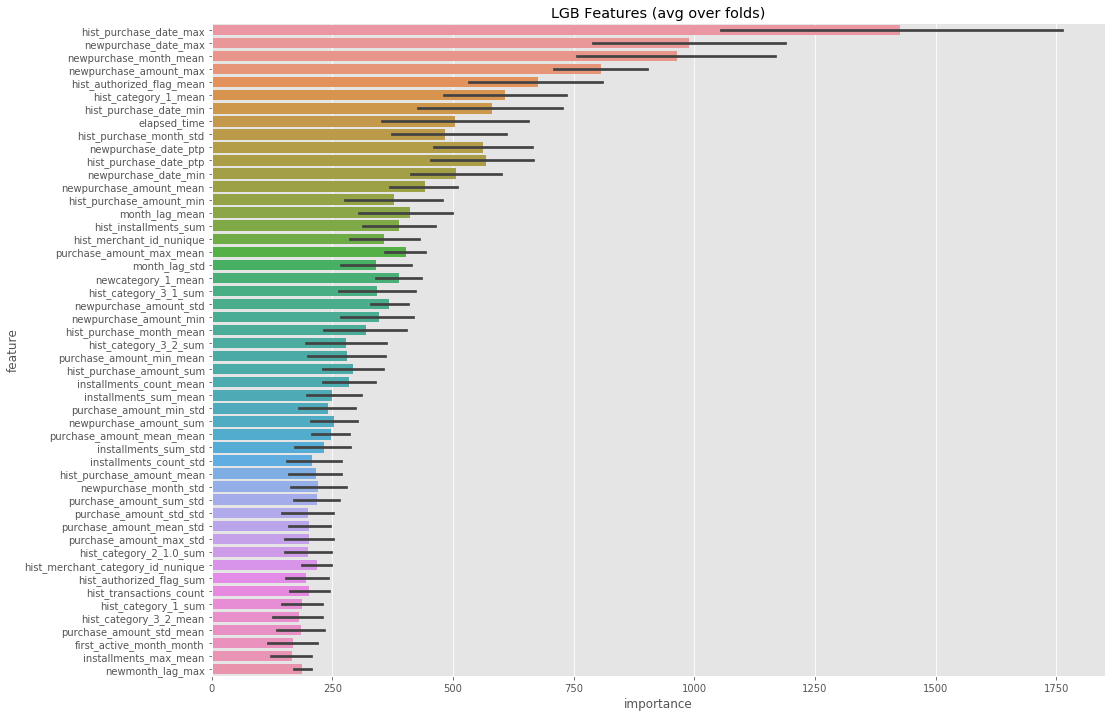

In [241]:

oof_lgb, prediction_lgb, feature_importance = train_model(params=params, model_type='lgb', plot_feature_importance=True)

In [242]:
submission['target'] = prediction_lgb
submission.to_csv('lgb.csv', index=False)

In [120]:

xgb_params = {'eta': 0.01, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}
oof_xgb, prediction_xgb = train_model(params=xgb_params, model_type='xgb')

Fold 0 started at Fri Dec 14 14:29:36 2018
[0]	train-rmse:3.92747	valid_data-rmse:4.01768
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.78009	valid_data-rmse:3.71677
Stopping. Best iteration:
[716]	train-rmse:2.61522	valid_data-rmse:3.71468

Fold 1 started at Fri Dec 14 14:35:21 2018
[0]	train-rmse:3.95221	valid_data-rmse:3.91746
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.77498	valid_data-rmse:3.64523
Stopping. Best iteration:
[730]	train-rmse:2.60234	valid_data-rmse:3.64472

Fold 2 started at Fri Dec 14 14:41:19 2018
[0]	train-rmse:3.93445	valid_data-rmse:3.98865
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

In [121]:
submission['target'] = prediction_xgb
submission.to_csv('xgb.csv', index=False)

In [141]:
#train.isnull().any().any()

True

In [185]:
inds = np.where(np.isnan(train))
#col_mean = np.nanmean(train, axis=0)
#print(col_mean)
#train[inds] = np.take(col_mean, inds[1])

#[train[col].fillna(train[col].mean(), inplace=True) for col in train.columns]

# replace Nan to inf
for col in train.columns:
    train[col] = train.loc[train[col] == np.nan,col] = 0
#train.fillna(train.mean(axis=0))
#inds = np.where(np.isnan(train))



In [186]:
# replace Nan to inf
for col in test.columns:
    test[col] = test.loc[test[col] == np.nan,col] = 0

In [187]:
oof_rcv, prediction_rcv = train_model(params=None, model_type='rcv')

Fold 0 started at Mon Dec 17 13:57:46 2018
0.1
Fold 0. RMSE: 3.9166.

Fold 1 started at Mon Dec 17 13:57:49 2018
0.1
Fold 1. RMSE: 3.8194.

Fold 2 started at Mon Dec 17 13:57:52 2018
0.1
Fold 2. RMSE: 3.8930.

Fold 3 started at Mon Dec 17 13:57:56 2018
0.1
Fold 3. RMSE: 3.8180.

Fold 4 started at Mon Dec 17 13:57:59 2018
0.1
Fold 4. RMSE: 3.8042.

CV mean score: 3.8502, std: 0.0455.


In [188]:
submission['target'] = prediction_rcv
submission.to_csv('rcv.csv', index=False)

In [190]:
cat_params = {'learning_rate': 0.01,
              'depth': 9,
              'l2_leaf_reg': 10,
              'bootstrap_type': 'Bernoulli',
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 50,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat, prediction_cat = train_model(params=cat_params, model_type='cat')

Fold 0 started at Mon Dec 17 14:03:07 2018


CatboostError: catboost/libs/algo/quantization.cpp:390: Train dataset is empty after binarization

In [191]:
#submission['target'] = (prediction_lgb + prediction_xgb + prediction_rcv + prediction_cat) / 4
submission['target'] = (prediction_lgb + prediction_xgb + prediction_rcv) / 3
submission.to_csv('blend.csv', index=False)


In [194]:
#train_stack = np.vstack([oof_lgb, oof_xgb, oof_rcv, oof_cat]).transpose()
train_stack = np.vstack([oof_lgb, oof_xgb, oof_rcv]).transpose()
train_stack = pd.DataFrame(train_stack)
#test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_rcv, prediction_cat]).transpose()
test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_rcv]).transpose()
test_stack = pd.DataFrame(test_stack)


In [195]:
oof_lgb_stack, prediction_lgb_stack = train_model(X=train_stack, X_test=test_stack, params=params, model_type='lgb')

Fold 0 started at Mon Dec 17 16:23:06 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[204]	training's rmse: 3.63608	valid_1's rmse: 3.71306
Fold 1 started at Mon Dec 17 16:23:08 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[117]	training's rmse: 3.65721	valid_1's rmse: 3.64409
Fold 2 started at Mon Dec 17 16:23:09 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[219]	training's rmse: 3.64085	valid_1's rmse: 3.68273
Fold 3 started at Mon Dec 17 16:23:11 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[111]	training's rmse: 3.6536	valid_1's rmse: 3.6668
Fold 4 started at Mon Dec 17 16:23:13 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[167]	training's rmse: 3.65958	valid_1's rmse: 3.62492
CV mean score: 3.6663,

In [196]:
sample_submission = pd.read_csv('./input/sample_submission.csv')
sample_submission['target'] = prediction_lgb_stack
sample_submission.to_csv('stacker_lgb.csv', index=False)


In [197]:
oof_rcv_stack, prediction_rcv_stack = train_model(X=train_stack, X_test=test_stack, params=None, model_type='rcv')

Fold 0 started at Mon Dec 17 16:23:20 2018
100.0
Fold 0. RMSE: 3.7067.

Fold 1 started at Mon Dec 17 16:23:20 2018
1.0
Fold 1. RMSE: 3.6351.

Fold 2 started at Mon Dec 17 16:23:20 2018
1.0
Fold 2. RMSE: 3.6752.

Fold 3 started at Mon Dec 17 16:23:20 2018
1.0
Fold 3. RMSE: 3.6679.

Fold 4 started at Mon Dec 17 16:23:20 2018
0.1
Fold 4. RMSE: 3.6153.

CV mean score: 3.6600, std: 0.0319.


In [198]:
sample_submission = pd.read_csv('./input/sample_submission.csv')
sample_submission['target'] = prediction_rcv_stack
sample_submission.to_csv('stacker_rcv.csv', index=False)